In [ ]:
!pip install utm
!pip install geojson 
!pip install geopandas

# 시각화 도구 설치
!pip install plotnine #R 시각화 
!pip install folium #지도 시각화 

In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [1]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [2]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
import folium 
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import utm
from shapely.geometry import Point, Polygon
from plotnine import *

In [5]:
target_pop = pd.read_excel('/content/drive/My Drive/Project/Seoul/수요_target/행정동_초등학생인구.xlsx')
target_pop

,행정동코드,자치구,행정동,05-09세,10-14세,05-14세
0,1168066000,강남구,개포1동,270,288,558
1,1168067000,강남구,개포2동,944,1136,2080
2,1168069000,강남구,개포4동,629,739,1368
3,1168052100,강남구,논현1동,364,386,750
4,1168053100,강남구,논현2동,616,565,1181
...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,351,341,692
421,1126068000,중랑구,신내1동,2239,2010,4249
422,1126069000,중랑구,신내2동,787,834,1621
423,1126060000,중랑구,중화제1동,679,644,1323


In [6]:
len(target_pop['행정동'].unique()), len(target_pop['행정동코드'].unique())

(424, 425)

# Ver1. 동별 전출입

In [7]:
dong = pd.read_excel('/content/drive/My Drive/Project/Seoul/인구/동별_전입전출.xlsx')
dong

,행정동코드,자치구,동,총전입,총전출,구내전입,구내전출,구간전입,구간전출,시ㆍ도간전입,시ㆍ도간전출
0,1168066000,강남구,개포1동,618.0,1486.0,284.0,618.0,186.0,528.0,148,340.0
1,1168067000,강남구,개포2동,10504.0,2415.0,4023.0,660.0,3980.0,898.0,2501,857.0
2,1168069000,강남구,개포4동,2202.0,2776.0,411.0,507.0,1002.0,1117.0,789,1152.0
3,1168052100,강남구,논현1동,5190.0,5507.0,953.0,1153.0,2014.0,2366.0,2223,1988.0
4,1168053100,강남구,논현2동,4313.0,4748.0,1280.0,1372.0,1480.0,1829.0,1553,1547.0
...,...,...,...,...,...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,4095.0,3543.0,1250.0,1184.0,1536.0,1059.0,1309,1300.0
421,1126068000,중랑구,신내1동,3604.0,4000.0,1620.0,1072.0,1057.0,1152.0,927,1776.0
422,1126069000,중랑구,신내2동,2217.0,2705.0,881.0,789.0,739.0,910.0,597,1006.0
423,1126060000,중랑구,중화제1동,2808.0,2996.0,1107.0,1030.0,997.0,899.0,704,1067.0


In [8]:
df_dong = target_pop.merge(dong.drop(['자치구','동'], axis=1), on='행정동코드')
df_dong

,행정동코드,자치구,행정동,05-09세,10-14세,05-14세,총전입,총전출,구내전입,구내전출,구간전입,구간전출,시ㆍ도간전입,시ㆍ도간전출
0,1168066000,강남구,개포1동,270,288,558,618.0,1486.0,284.0,618.0,186.0,528.0,148,340.0
1,1168067000,강남구,개포2동,944,1136,2080,10504.0,2415.0,4023.0,660.0,3980.0,898.0,2501,857.0
2,1168069000,강남구,개포4동,629,739,1368,2202.0,2776.0,411.0,507.0,1002.0,1117.0,789,1152.0
3,1168052100,강남구,논현1동,364,386,750,5190.0,5507.0,953.0,1153.0,2014.0,2366.0,2223,1988.0
4,1168053100,강남구,논현2동,616,565,1181,4313.0,4748.0,1280.0,1372.0,1480.0,1829.0,1553,1547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,351,341,692,4095.0,3543.0,1250.0,1184.0,1536.0,1059.0,1309,1300.0
421,1126068000,중랑구,신내1동,2239,2010,4249,3604.0,4000.0,1620.0,1072.0,1057.0,1152.0,927,1776.0
422,1126069000,중랑구,신내2동,787,834,1621,2217.0,2705.0,881.0,789.0,739.0,910.0,597,1006.0
423,1126060000,중랑구,중화제1동,679,644,1323,2808.0,2996.0,1107.0,1030.0,997.0,899.0,704,1067.0


In [9]:
df_dong.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정동코드   425 non-null    int64  
 1   자치구     425 non-null    object 
 2   행정동     425 non-null    object 
 3   05-09세  425 non-null    int64  
 4   10-14세  425 non-null    int64  
 5   05-14세  425 non-null    int64  
 6   총전입     425 non-null    float64
 7   총전출     425 non-null    float64
 8   구내전입    425 non-null    float64
 9   구내전출    425 non-null    float64
 10  구간전입    425 non-null    float64
 11  구간전출    425 non-null    float64
 12  시ㆍ도간전입  425 non-null    int64  
 13  시ㆍ도간전출  425 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 49.8+ KB


### 모델링

In [10]:
y = df_dong[['05-14세']]
X = df_dong.drop(['행정동코드', '자치구', '행정동', '05-09세', '10-14세', '05-14세'], axis=1)

X.shape, y.shape

((425, 8), (425, 1))

In [11]:
X.columns

Index(['총전입', '총전출', '구내전입', '구내전출', '구간전입', '구간전출', '시ㆍ도간전입', '시ㆍ도간전출'], dtype='object')

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape

((340, 8), (85, 8), (340, 1))

train R2 score : 0.9707345733140467
test R2 score : 0.1520695050530022


-----------
rmse: 1082.061273689862
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




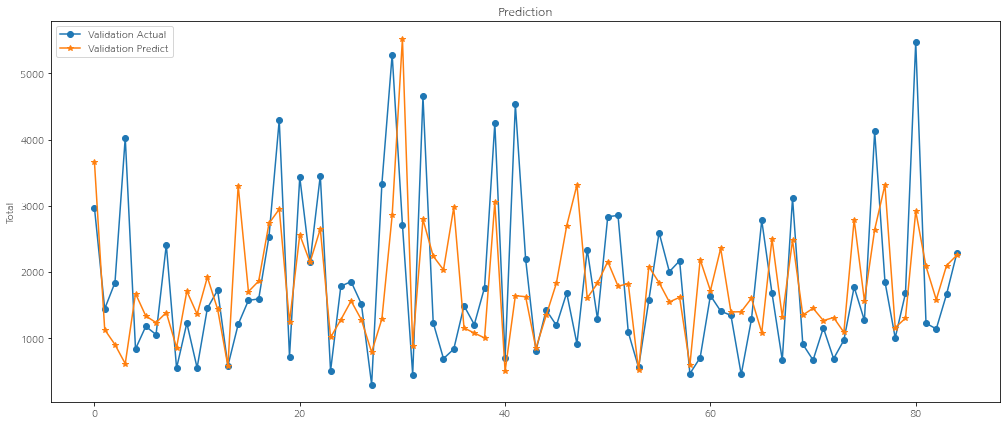

In [13]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  3, 
                       min_child_weight = 1, 
                        n_estimators =500, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

print('train R2 score : {}'.format(xgb_model.score(X_train, y_train)))
print('test R2 score : {}'.format(xgb_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')


# 예측값과 실제값 그래프 출력 
pred_train = xgb_model.predict(X_train)
pred_val = xgb_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction')
plt.ylabel('Total')
plt.legend()

## 동명씨 Data 포함

In [14]:
df_feature = pd.read_csv('/content/drive/My Drive/Project/Seoul/가공데이터/total_합치기.csv').drop(['Unnamed: 0','시군구명','행정동명','5~9세', '10~14세','5~14세'], axis=1)
df_feature

,행정동코드,공동주택_개수,공동주택_건축면적(㎡),공동주택_건폐율(%),공동주택_연면적(㎡),공동주택_용적률(%),공동주택_세대수,공동주택_가구수,단독주택_개수,단독주택_건축면적(㎡),단독주택_건폐율(%),단독주택_가구수,공장_개수,공장_건축면적(㎡),동별총학원,동별입시학원수,버스정류장,도서관,박물관/미술관,공원,지하철역,병원수,유통개수,아동 비율
0,1111051500,379,125.269681,52.555743,191.928277,964.553177,7.379947,0.005277,1559.0,23.462012,13.678553,1.304041,1.0,0.00,58.380856,5.365593,25.0,3.0,1.0,0.0,0.0,6,0,0.101799
1,1111053000,98,348.211020,44.991429,153.290797,3228.286531,17.010204,0.071429,946.0,12.173044,8.226060,1.180761,4.0,0.00,44.447564,4.085030,24.0,0.0,5.0,2.0,2.0,37,1,0.099424
2,1111054000,14,203.559286,34.089286,113.165714,746.249643,4.357143,0.000000,729.0,18.521756,11.591167,1.226337,2.0,0.00,13.501850,1.240911,23.0,1.0,7.0,1.0,0.0,86,0,0.059029
3,1111055000,246,124.504472,24.580998,61.007185,902.087581,6.914634,0.069106,1109.0,33.162876,11.441231,1.220018,1.0,0.00,47.326869,4.349657,60.0,0.0,5.0,0.0,0.0,12,0,0.030142
4,1111056000,454,389.523883,20.485875,59.479189,1422.534819,8.856828,0.002203,1625.0,67.452961,15.599884,1.156923,2.0,0.00,84.907700,7.803588,34.0,1.0,6.0,0.0,0.0,65,5,0.029561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1174065000,1247,193.674798,46.141739,178.642433,1268.791290,13.827586,0.003208,1944.0,84.791241,40.042056,3.489198,0.0,0.00,118.099591,22.728190,25.0,0.0,0.0,0.0,1.0,12,0,0.070858
421,1174066000,1247,193.674798,46.141739,178.642433,1268.791290,13.827586,0.003208,1944.0,84.791241,40.042056,3.489198,0.0,0.00,112.113670,21.576204,25.0,1.0,0.0,0.0,1.0,15,0,0.063964
422,1174068500,683,232.939603,41.283617,176.225471,1810.938666,20.751098,0.055637,805.0,95.671335,39.313429,4.043478,0.0,0.00,220.942613,42.520263,16.0,0.0,0.0,1.0,1.0,28,0,0.043771
423,1174069000,359,231.635373,36.682957,139.272450,2113.655245,20.142061,0.000000,594.0,77.712534,34.458581,2.462963,1.0,1109.58,1.289420,0.248148,46.0,0.0,0.0,0.0,0.0,8,0,0.068439


In [15]:
df_1 = target_pop.merge(df_feature, on='행정동코드')
df = df_1.merge(dong.drop(['자치구','동'], axis=1), on='행정동코드')
df

,행정동코드,자치구,행정동,05-09세,10-14세,05-14세,공동주택_개수,공동주택_건축면적(㎡),공동주택_건폐율(%),공동주택_연면적(㎡),공동주택_용적률(%),공동주택_세대수,공동주택_가구수,단독주택_개수,단독주택_건축면적(㎡),단독주택_건폐율(%),단독주택_가구수,공장_개수,공장_건축면적(㎡),동별총학원,동별입시학원수,버스정류장,도서관,박물관/미술관,공원,지하철역,병원수,유통개수,아동 비율,총전입,총전출,구내전입,구내전출,구간전입,구간전출,시ㆍ도간전입,시ㆍ도간전출
0,1168066000,강남구,개포1동,270,288,558,629,269.017886,36.968351,133.345931,2976.035567,28.483307,0.000000,358.0,92.183317,32.172585,4.069832,0.0,0.00,88.875012,15.395968,18.0,0.0,0.0,0.0,0.0,1,0,0.063987,618.0,1486.0,284.0,618.0,186.0,528.0,148,340.0
1,1168067000,강남구,개포2동,944,1136,2080,979,799.580737,32.101393,121.000889,2940.591695,29.281920,0.000000,967.0,97.405425,26.323076,2.538780,0.0,0.00,292.316180,50.638423,35.0,0.0,1.0,0.0,0.0,28,0,0.078849,10504.0,2415.0,4023.0,660.0,3980.0,898.0,2501,857.0
2,1168069000,강남구,개포4동,629,739,1368,629,269.017886,36.968351,133.345931,2976.035567,28.483307,0.000000,358.0,92.183317,32.172585,4.069832,0.0,0.00,236.239198,40.924114,18.0,1.0,0.0,0.0,0.0,16,0,0.068792,2202.0,2776.0,411.0,507.0,1002.0,1117.0,789,1152.0
3,1168052100,강남구,논현1동,364,386,750,961,261.955671,45.161495,163.530525,1419.158716,13.428720,0.056191,1410.0,132.040855,47.608796,6.975177,0.0,0.00,310.161213,53.729749,15.0,1.0,0.0,0.0,2.0,29,1,0.131267,5190.0,5507.0,953.0,1153.0,2014.0,2366.0,2223,1988.0
4,1168053100,강남구,논현2동,616,565,1181,961,261.955671,45.161495,163.530525,1419.158716,13.428720,0.056191,1410.0,132.040855,47.608796,6.975177,0.0,0.00,283.380694,49.090514,15.0,1.0,0.0,0.0,1.0,32,0,0.043701,4313.0,4748.0,1280.0,1372.0,1480.0,1829.0,1553,1547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,351,341,692,562,203.985837,42.190352,183.659167,1994.888895,20.887900,0.000000,1484.0,68.910519,39.724194,2.731806,5.0,549.34,39.428404,8.126465,28.0,1.0,0.0,0.0,1.0,19,0,0.076154,4095.0,3543.0,1250.0,1184.0,1536.0,1059.0,1309,1300.0
421,1126068000,중랑구,신내1동,2239,2010,4249,423,1655.203444,174.582301,2157.792905,5813.562125,49.541371,0.000000,482.0,73.458382,37.196929,2.516598,1.0,6209.83,79.917494,16.471545,50.0,0.0,0.0,0.0,0.0,146,6,0.046845,3604.0,4000.0,1620.0,1072.0,1057.0,1152.0,927,1776.0
422,1126069000,중랑구,신내2동,787,834,1621,423,1655.203444,174.582301,2157.792905,5813.562125,49.541371,0.000000,482.0,73.458382,37.196929,2.516598,1.0,6209.83,42.537651,8.767302,50.0,0.0,0.0,0.0,1.0,77,0,0.087721,2217.0,2705.0,881.0,789.0,739.0,910.0,597,1006.0
423,1126060000,중랑구,중화제1동,679,644,1323,641,277.986507,39.349551,143.189185,1210.363672,13.864275,0.000000,2838.0,70.631441,39.830263,2.801268,3.0,95.29,40.733107,8.395373,47.0,0.0,0.0,0.0,1.0,51,1,0.050491,2808.0,2996.0,1107.0,1030.0,997.0,899.0,704,1067.0


In [16]:
y = df[['05-14세']]
X = df.drop(['행정동코드', '자치구', '행정동', '05-09세', '10-14세', '05-14세'], axis=1)

X.shape, y.shape

((425, 31), (425, 1))

In [17]:
X.columns

Index(['공동주택_개수', '공동주택_건축면적(㎡)', '공동주택_건폐율(%)', '공동주택_연면적(㎡)', '공동주택_용적률(%)',
       '공동주택_세대수', '공동주택_가구수', '단독주택_개수', '단독주택_건축면적(㎡)', '단독주택_건폐율(%)',
       '단독주택_가구수', '공장_개수', '공장_건축면적(㎡)', '동별총학원', '동별입시학원수', '버스정류장', '도서관',
       '박물관/미술관', '공원', '지하철역', '병원수', '유통개수', '아동 비율', '총전입', '총전출', '구내전입',
       '구내전출', '구간전입', '구간전출', '시ㆍ도간전입', '시ㆍ도간전출'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape

((340, 31), (85, 31), (340, 1))

train R2 score : 0.9999985584463691
test R2 score : 0.5188968609619111


-----------
rmse: 815.0623309945688
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




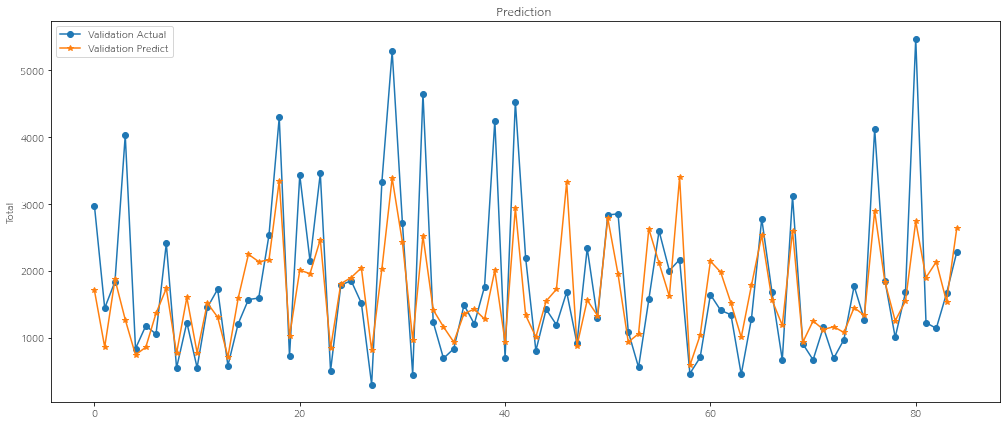

In [19]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  6, 
                       min_child_weight = 1, 
                        n_estimators =500, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

print('train R2 score : {}'.format(xgb_model.score(X_train, y_train)))
print('test R2 score : {}'.format(xgb_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')



# 예측값과 실제값 그래프 출력 
pred_train = xgb_model.predict(X_train)
pred_val = xgb_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Total')
plt.legend()

## ExtraTreesRegressor

전체 트리 모델에서 각 변수의 중요도 추출

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

etc_model = ExtraTreesRegressor()
etc_model.fit(X_train, y_train)

# print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)

# 중요도 순으로 특성 출력 
feature_list = feature_list.sort_values("importance", ascending =False).reset_index()
feature_list[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,index,features_name,importance
0,14,동별입시학원수,0.281618
1,13,동별총학원,0.133399
2,24,총전출,0.045849
3,16,도서관,0.042376
4,15,버스정류장,0.039867
5,2,공동주택_건폐율(%),0.037504
6,28,구간전출,0.032594
7,27,구간전입,0.031212
8,23,총전입,0.030933
9,25,구내전입,0.030596


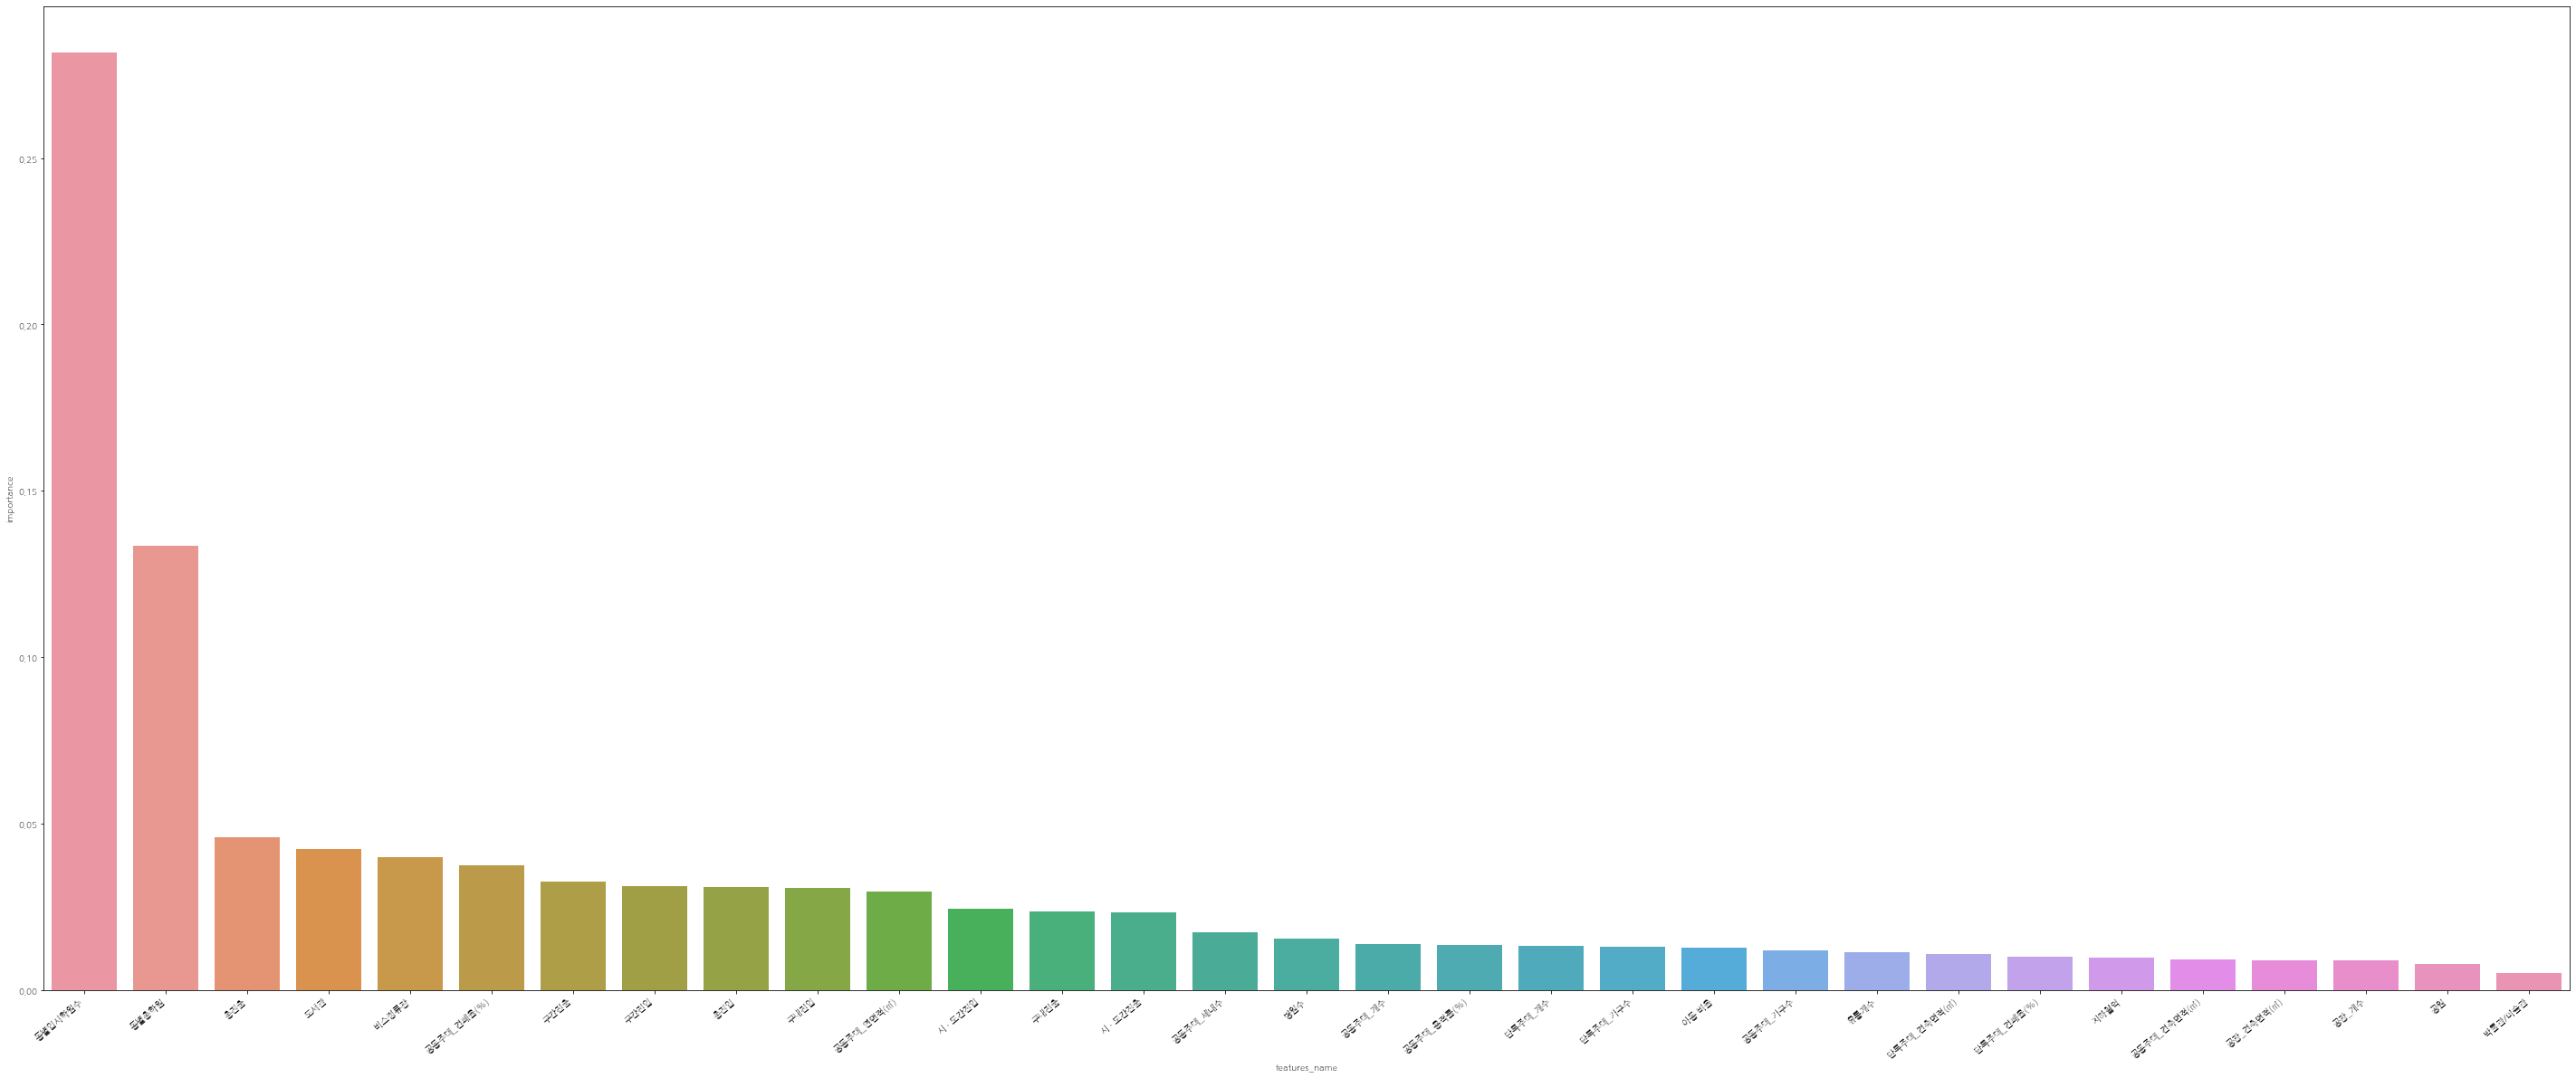

In [21]:
# 특성 중요도 그래프 그리기
plt.figure(figsize = (50,20))
ax = sns.barplot(x = feature_list['features_name'], y = feature_list['importance'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

fig = plt.gcf()
fig.savefig('graph.png', dpi=300, format='png', bbox_inches="tight", facecolor="white")


## RFE

In [22]:
# XGBoost model with RFE and 20 features
import xgboost as xgb
from sklearn.feature_selection import RFE

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  6, 
                       min_child_weight = 1, 
                        n_estimators =1000, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

selector = RFE(xgb_model, 20, step=1)
selector.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=0.5, gamma=0.0,
                           importance_type='gain', learning_rate=0.05,
                           max_delta_step=0, max_depth=6, min_child_weight=1,
                           missing=None, n_estimators=1000, n_jobs=1,
                           nthread=None, objective='reg:squarederror',
                           random_state=545, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=None, silent=None,
                           subsample=1.0, verbosity=1),
    n_features_to_select=20, step=1, verbose=0)

train R2 score : 0.9999999997848105
test R2 score : 0.5472707271782331


-----------
rmse: 790.6622701473829
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




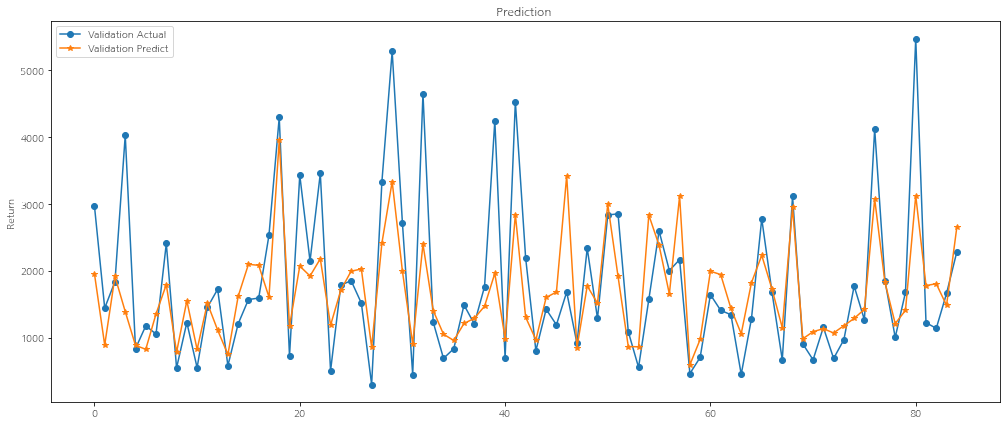

In [23]:
print('train R2 score : {}'.format(selector.score(X_train, y_train)))
print('test R2 score : {}'.format(selector.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, selector.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')


pred_train = selector.predict(X_train)
pred_val = selector.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Return')
plt.legend()

In [24]:
feature_rank = pd.DataFrame([X_train.columns, selector.ranking_]).T
feature_rank = feature_rank.sort_values(1, ascending = True).reset_index()

print(feature_rank[:50])

    index             0   1
0      15         버스정류장   1
1      28          구간전출   1
2      27          구간전입   1
3      26          구내전출   1
4      25          구내전입   1
5      24           총전출   1
6      23           총전입   1
7      22         아동 비율   1
8      20           병원수   1
9      29        시ㆍ도간전입   1
10     14       동별입시학원수   1
11     13         동별총학원   1
12     30        시ㆍ도간전출   1
13     10      단독주택_가구수   1
14      9   단독주택_건폐율(%)   1
15      2   공동주택_건폐율(%)   1
16      8  단독주택_건축면적(㎡)   1
17      3   공동주택_연면적(㎡)   1
18      5      공동주택_세대수   1
19      4   공동주택_용적률(%)   1
20     19          지하철역   2
21      6      공동주택_가구수   3
22     11         공장_개수   4
23      1  공동주택_건축면적(㎡)   5
24     16           도서관   6
25     12    공장_건축면적(㎡)   7
26      0       공동주택_개수   8
27      7       단독주택_개수   9
28     17       박물관/미술관  10
29     18            공원  11
30     21          유통개수  12


In [25]:
# XGBoost model with RFE and 20 features
import xgboost as xgb
from sklearn.feature_selection import RFE

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  6, 
                       min_child_weight = 1, 
                        n_estimators =1000, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

selector = RFE(xgb_model, 15, step=1)
selector.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=0.5, gamma=0.0,
                           importance_type='gain', learning_rate=0.05,
                           max_delta_step=0, max_depth=6, min_child_weight=1,
                           missing=None, n_estimators=1000, n_jobs=1,
                           nthread=None, objective='reg:squarederror',
                           random_state=545, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=None, silent=None,
                           subsample=1.0, verbosity=1),
    n_features_to_select=15, step=1, verbose=0)

train R2 score : 0.9999999987945463
test R2 score : 0.5237649211998868


-----------
rmse: 810.9282271823744
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




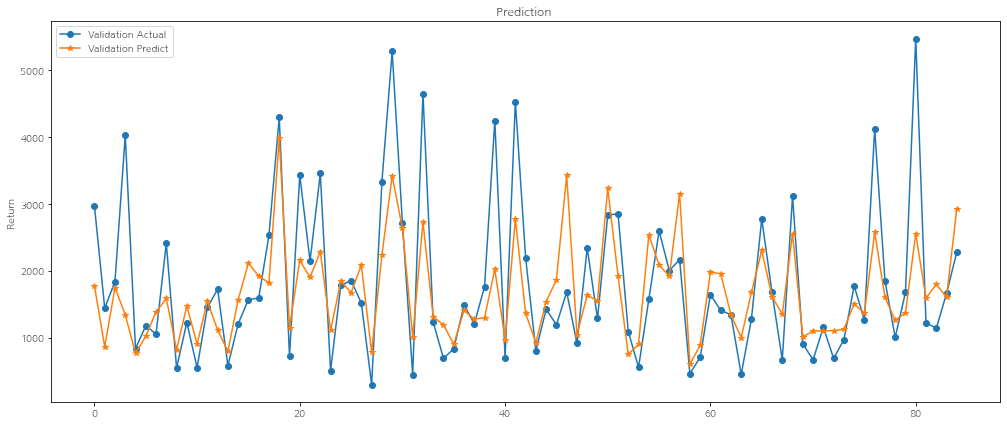

In [26]:
print('train R2 score : {}'.format(selector.score(X_train, y_train)))
print('test R2 score : {}'.format(selector.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, selector.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')

pred_train = selector.predict(X_train)
pred_val = selector.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Return')
plt.legend()

## Model GridSearch

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 
from sklearn import linear_model as lm 
import xgboost as xgb 
from scipy.stats import uniform, randint 

models = [ 
          ('lr', lm.LinearRegression(n_jobs=-1)),
          ('ridge', lm.Ridge()), ('lasso', lm.Lasso()), 
          ('elastic', lm.ElasticNet()), 
          ('LassoLars', lm.LassoLars()), 
          # ('LogisticRegression', lm.LogisticRegression()), 
          ('SGDRegressor', lm.SGDRegressor()), 
          ('Perceptron', lm.Perceptron(n_jobs=-1)), 
          ('xgboost', xgb.XGBRegressor())
          ] 
 
n = 3 
params = { 'lr' : { 'fit_intercept': [True, False], 'normalize': [True, False], }, 
          'ridge': { 'alpha': [0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], 
                    'normalize': [True, False], }, 
          'lasso': { 'alpha': [0.1, 1.0, 10], 'fit_intercept': [True, False], 'normalize': [True, False], }, 
          'elastic': { 'alpha': [0.1, 1.0, 10], 'normalize': [True, False], 'fit_intercept': [True, False], }, 
          'LassoLars': { 'alpha': [0.1, 1.0, 10], 'normalize': [True, False], 'fit_intercept': [True, False], },  
          # 'LogisticRegression': { 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], },
          'SGDRegressor': { 'penalty': ['l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], },
          'Perceptron' :{ 'penalty': ['None', 'l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False] },
          'xgboost': { "gamma": uniform(0, 0.5).rvs(n), 
                      "max_depth": range(2, 7), # default 3 
                      "n_estimators": randint(100, 150).rvs(n), # default 100 
                      }

}

best_model, best_rmse = None, float('inf') 

for model_name, model in models: 
  param_grid = params[model_name] 
  grid = GridSearchCV(model, cv=3, n_jobs=-1, param_grid=param_grid) 
  grid = grid.fit(X_train, y_train) 

  model = grid.best_estimator_ 
  predictions = model.predict(X_test) 
  rmse = np.sqrt(mean_squared_error(y_train,model.predict(X_train)))
  print(model_name, rmse) 
  
  if rmse < best_rmse: 
    best_model = model


lr 679.3876419972169
ridge 680.3942490918604
lasso 697.5950257551706


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19482313.60007991, tolerance: 44002.38527382353
  positive)


elastic 680.8747020050611
LassoLars 697.5802843184308


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


SGDRegressor 5.059463482357494e+16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Perceptron 1281.6301808978421
[10:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost 374.6763107535019


In [28]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.04162398131138012,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=120,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[Text(0, 0, '공동주택_개수'),
 Text(0, 0, '공동주택_건축면적(㎡)'),
 Text(0, 0, '공동주택_건폐율(%)'),
 Text(0, 0, '공동주택_연면적(㎡)'),
 Text(0, 0, '공동주택_용적률(%)'),
 Text(0, 0, '공동주택_세대수'),
 Text(0, 0, '공동주택_가구수'),
 Text(0, 0, '단독주택_개수'),
 Text(0, 0, '단독주택_건축면적(㎡)'),
 Text(0, 0, '단독주택_건폐율(%)'),
 Text(0, 0, '단독주택_가구수'),
 Text(0, 0, '공장_개수'),
 Text(0, 0, '공장_건축면적(㎡)'),
 Text(0, 0, '동별총학원'),
 Text(0, 0, '동별입시학원수'),
 Text(0, 0, '버스정류장'),
 Text(0, 0, '도서관'),
 Text(0, 0, '박물관/미술관'),
 Text(0, 0, '공원'),
 Text(0, 0, '지하철역'),
 Text(0, 0, '병원수'),
 Text(0, 0, '유통개수'),
 Text(0, 0, '아동 비율'),
 Text(0, 0, '총전입'),
 Text(0, 0, '총전출'),
 Text(0, 0, '구내전입'),
 Text(0, 0, '구내전출'),
 Text(0, 0, '구간전입'),
 Text(0, 0, '구간전출'),
 Text(0, 0, '시ㆍ도간전입'),
 Text(0, 0, '시ㆍ도간전출')]

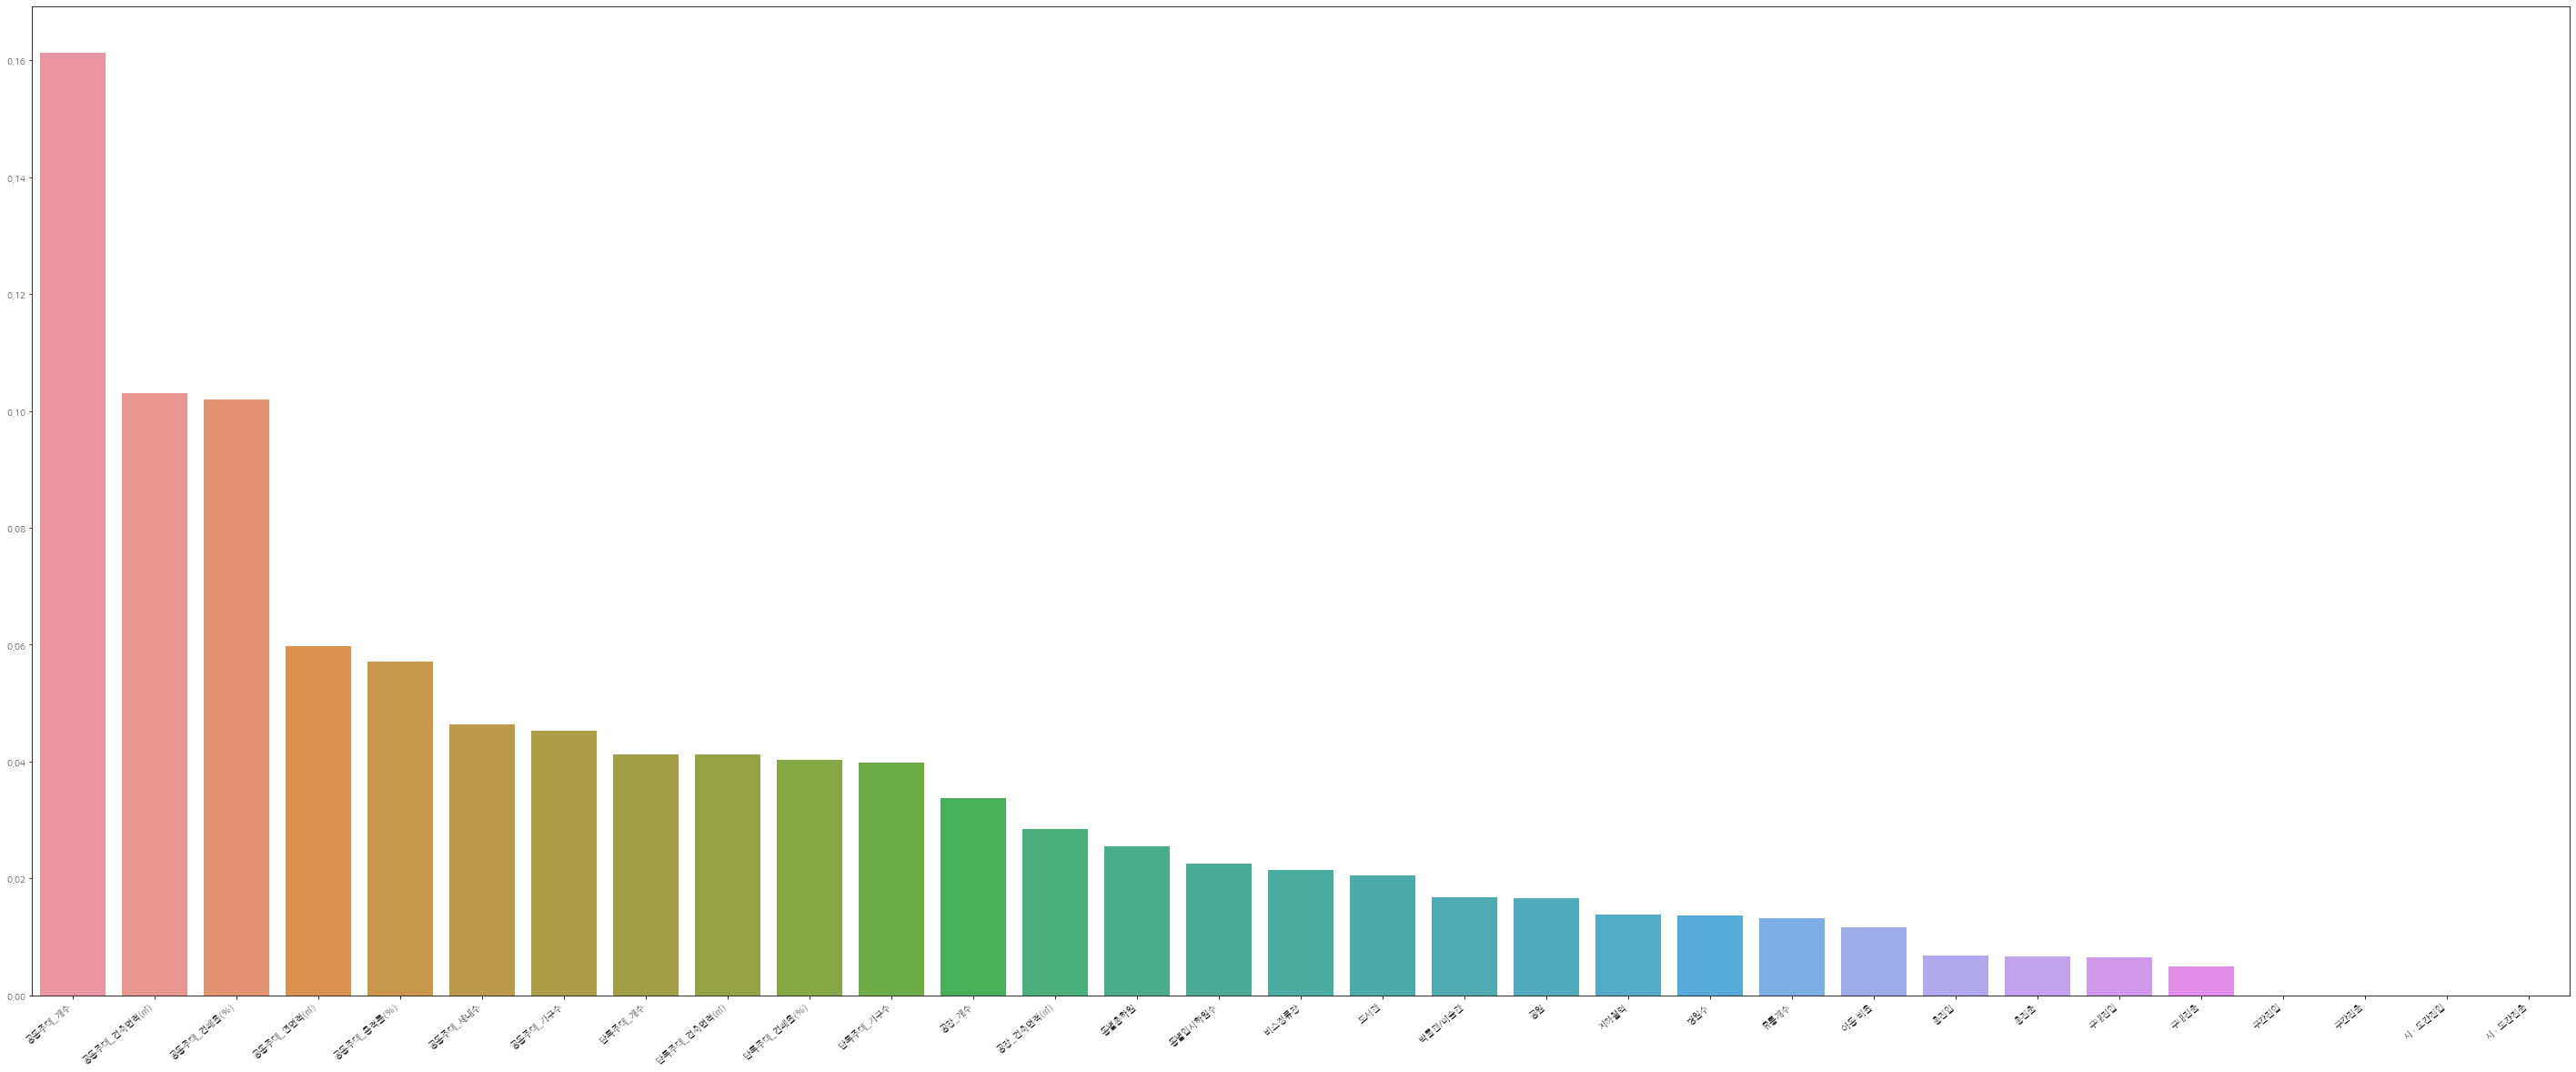

In [29]:
# 특성 중요도 그래프 그리기
features = X.columns
feature_importance = pd.Series(index=features, data=best_model.feature_importances_).sort_values(ascending=False) 

plt.figure(figsize = (50,20))
ax = sns.barplot(x = features, y = feature_importance)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# fig = plt.gcf()
# fig.savefig('graph.png', dpi=300, format='png', bbox_inches="tight", facecolor="white")

train R2 score : 0.8915286192588643
test R2 score : 0.5698315861901289


-----------
rmse: 770.7099857156562
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




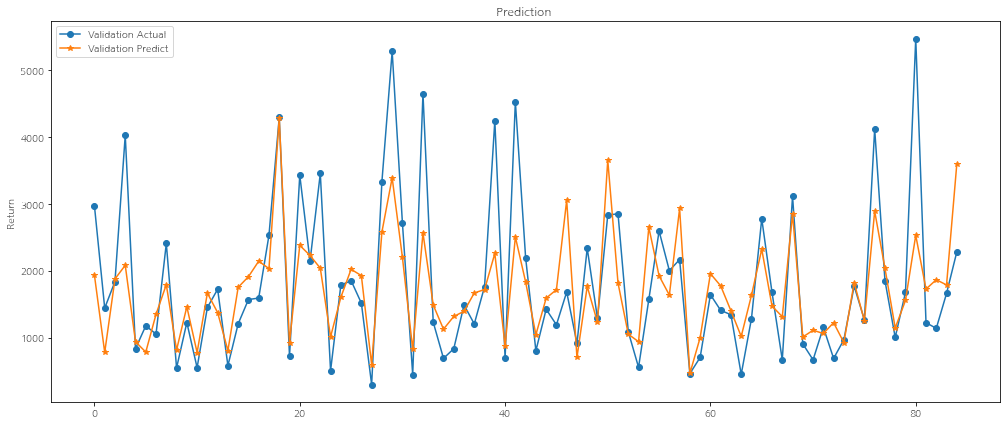

In [30]:
print('train R2 score : {}'.format(best_model.score(X_train, y_train)))
print('test R2 score : {}'.format(best_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')

pred_train = best_model.predict(X_train)
pred_val = best_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Return')
plt.legend()

# ver2. 동별 + 연령별 전입전출 

In [31]:
move = pd.read_pickle('/content/drive/My Drive/Project/Seoul/가공데이터/행정동별_연령별_전입전출.pickle')
move

,자치구,행정동,행정동코드,총전입_00 - 04세,총전입_05 - 09세,총전입_10 - 14세,총전입_15 - 19세,총전입_20 - 24세,총전입_25 - 29세,총전입_30 - 34세,총전입_35 - 39세,총전입_40 - 44세,총전입_45 - 49세,총전입_50 - 54세,총전입_55 - 59세,총전입_60 - 64세,총전입_65 - 69세,총전입_70 - 74세,총전입_75 - 79세,총전입_80세이상,총전출_00 - 04세,총전출_05 - 09세,총전출_10 - 14세,총전출_15 - 19세,총전출_20 - 24세,총전출_25 - 29세,총전출_30 - 34세,총전출_35 - 39세,총전출_40 - 44세,총전출_45 - 49세,총전출_50 - 54세,총전출_55 - 59세,총전출_60 - 64세,총전출_65 - 69세,총전출_70 - 74세,총전출_75 - 79세,총전출_80세이상
0,강남구,개포1동,1168066000,4.951676,7.482255,8.902299,12.273633,20.145777,18.225438,15.850075,13.518597,13.246507,6.388350,8.409857,6.512616,5.161403,3.443861,2.374439,1.605749,1.975774,14.465583,12.801792,25.096178,33.279222,47.965662,51.125620,43.395616,30.940400,34.888648,12.014634,28.886994,22.559151,16.808935,11.011149,7.438925,4.923418,5.727564
1,강남구,개포2동,1168067000,84.162464,127.174123,151.310276,208.612045,342.413010,309.773458,269.399972,229.772399,225.147743,108.581278,142.940354,110.693387,87.727140,58.534487,40.357782,27.292539,33.581757,23.509006,20.805065,40.785512,54.084335,77.952271,83.087733,70.525177,50.283356,56.699923,19.525801,46.946226,36.662416,27.317347,17.894970,12.089504,8.001382,9.308256
2,강남구,개포4동,1168069000,17.643350,26.660074,31.719843,43.732266,71.781554,64.939181,56.475508,48.168205,47.198718,22.762374,29.965219,23.205145,18.390628,12.270844,8.460380,5.721456,7.039892,27.023189,23.915056,46.882228,62.168991,89.604763,95.507887,81.067450,57.799833,65.175564,22.444565,53.963860,42.142802,31.400810,20.569953,13.896673,9.197448,10.699676
3,강남구,논현1동,1168052100,41.584462,62.836415,74.762027,103.074687,169.185408,153.058287,133.109849,113.529965,111.244934,53.649736,70.626470,54.693324,43.345759,28.921743,19.940679,13.485175,16.592662,53.608321,47.442441,93.004477,123.330199,177.757000,189.467555,160.820766,114.662709,129.294607,44.525295,107.052946,83.602454,62.292601,40.806459,27.568075,18.245801,21.225907
4,강남구,논현2동,1168053100,34.557569,52.218392,62.128829,85.657249,140.596660,127.194680,110.617106,94.345807,92.446898,44.584068,58.692093,45.451312,36.021245,24.034581,16.571127,11.206466,13.788854,46.219776,40.903706,80.186173,106.332265,153.257715,163.354268,138.655711,98.859368,111.474632,38.388615,92.298418,72.079980,53.707149,35.182326,23.768516,15.731081,18.300455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,중랑구,상봉제2동,1126059000,40.320349,28.471514,45.129687,97.955497,151.118493,135.406807,109.609119,75.955588,84.473972,30.293502,81.628595,77.955042,59.185020,34.511285,24.064434,18.515653,20.592009,44.060816,26.717922,34.133785,67.050445,110.396370,114.341845,102.460175,69.828566,69.864763,31.912193,64.996265,65.281316,49.888536,30.364771,20.510133,15.605438,16.849710
421,중랑구,신내1동,1126068000,35.485846,25.057714,39.718533,86.210406,132.999035,119.171217,96.466731,66.848337,74.345346,26.661241,71.841137,68.608051,52.088599,30.373302,21.179052,16.295584,18.122980,49.744077,30.164179,38.536590,75.699063,124.636038,129.090426,115.676178,78.835525,78.876391,36.028443,73.379921,73.701740,56.323495,34.281423,23.155669,17.618332,19.023099
422,중랑구,신내2동,1126069000,21.829112,15.414248,24.432849,53.032317,81.814334,73.308154,59.341494,41.121743,45.733527,16.400658,44.193063,42.204231,32.042293,18.684132,13.028291,10.024226,11.148348,33.639432,20.398526,26.060369,51.191491,84.285120,87.297401,78.226016,53.312524,53.340159,24.364234,49.623171,49.840802,38.088763,23.182813,15.659021,11.914397,12.864371
423,중랑구,중화제1동,1126060000,27.648240,19.523324,30.946071,67.169484,103.624109,92.850382,75.160539,52.083832,57.925009,20.772687,55.973894,53.454886,40.584014,23.664881,16.501326,12.696448,14.120235,37.258314,22.592970,28.863906,56.698598,93.352392,96.688729,86.641457,59.047808,59.078417,26.985304,54.961560,55.202603,42.186298,25.676786,17.343596,13.196131,14.248302


In [32]:
df_move = target_pop.merge(move.drop(['자치구','행정동'], axis=1), on='행정동코드')
df_move

,행정동코드,자치구,행정동,05-09세,10-14세,05-14세,총전입_00 - 04세,총전입_05 - 09세,총전입_10 - 14세,총전입_15 - 19세,총전입_20 - 24세,총전입_25 - 29세,총전입_30 - 34세,총전입_35 - 39세,총전입_40 - 44세,총전입_45 - 49세,총전입_50 - 54세,총전입_55 - 59세,총전입_60 - 64세,총전입_65 - 69세,총전입_70 - 74세,총전입_75 - 79세,총전입_80세이상,총전출_00 - 04세,총전출_05 - 09세,총전출_10 - 14세,총전출_15 - 19세,총전출_20 - 24세,총전출_25 - 29세,총전출_30 - 34세,총전출_35 - 39세,총전출_40 - 44세,총전출_45 - 49세,총전출_50 - 54세,총전출_55 - 59세,총전출_60 - 64세,총전출_65 - 69세,총전출_70 - 74세,총전출_75 - 79세,총전출_80세이상
0,1168066000,강남구,개포1동,270,288,558,4.951676,7.482255,8.902299,12.273633,20.145777,18.225438,15.850075,13.518597,13.246507,6.388350,8.409857,6.512616,5.161403,3.443861,2.374439,1.605749,1.975774,14.465583,12.801792,25.096178,33.279222,47.965662,51.125620,43.395616,30.940400,34.888648,12.014634,28.886994,22.559151,16.808935,11.011149,7.438925,4.923418,5.727564
1,1168067000,강남구,개포2동,944,1136,2080,84.162464,127.174123,151.310276,208.612045,342.413010,309.773458,269.399972,229.772399,225.147743,108.581278,142.940354,110.693387,87.727140,58.534487,40.357782,27.292539,33.581757,23.509006,20.805065,40.785512,54.084335,77.952271,83.087733,70.525177,50.283356,56.699923,19.525801,46.946226,36.662416,27.317347,17.894970,12.089504,8.001382,9.308256
2,1168069000,강남구,개포4동,629,739,1368,17.643350,26.660074,31.719843,43.732266,71.781554,64.939181,56.475508,48.168205,47.198718,22.762374,29.965219,23.205145,18.390628,12.270844,8.460380,5.721456,7.039892,27.023189,23.915056,46.882228,62.168991,89.604763,95.507887,81.067450,57.799833,65.175564,22.444565,53.963860,42.142802,31.400810,20.569953,13.896673,9.197448,10.699676
3,1168052100,강남구,논현1동,364,386,750,41.584462,62.836415,74.762027,103.074687,169.185408,153.058287,133.109849,113.529965,111.244934,53.649736,70.626470,54.693324,43.345759,28.921743,19.940679,13.485175,16.592662,53.608321,47.442441,93.004477,123.330199,177.757000,189.467555,160.820766,114.662709,129.294607,44.525295,107.052946,83.602454,62.292601,40.806459,27.568075,18.245801,21.225907
4,1168053100,강남구,논현2동,616,565,1181,34.557569,52.218392,62.128829,85.657249,140.596660,127.194680,110.617106,94.345807,92.446898,44.584068,58.692093,45.451312,36.021245,24.034581,16.571127,11.206466,13.788854,46.219776,40.903706,80.186173,106.332265,153.257715,163.354268,138.655711,98.859368,111.474632,38.388615,92.298418,72.079980,53.707149,35.182326,23.768516,15.731081,18.300455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,351,341,692,40.320349,28.471514,45.129687,97.955497,151.118493,135.406807,109.609119,75.955588,84.473972,30.293502,81.628595,77.955042,59.185020,34.511285,24.064434,18.515653,20.592009,44.060816,26.717922,34.133785,67.050445,110.396370,114.341845,102.460175,69.828566,69.864763,31.912193,64.996265,65.281316,49.888536,30.364771,20.510133,15.605438,16.849710
421,1126068000,중랑구,신내1동,2239,2010,4249,35.485846,25.057714,39.718533,86.210406,132.999035,119.171217,96.466731,66.848337,74.345346,26.661241,71.841137,68.608051,52.088599,30.373302,21.179052,16.295584,18.122980,49.744077,30.164179,38.536590,75.699063,124.636038,129.090426,115.676178,78.835525,78.876391,36.028443,73.379921,73.701740,56.323495,34.281423,23.155669,17.618332,19.023099
422,1126069000,중랑구,신내2동,787,834,1621,21.829112,15.414248,24.432849,53.032317,81.814334,73.308154,59.341494,41.121743,45.733527,16.400658,44.193063,42.204231,32.042293,18.684132,13.028291,10.024226,11.148348,33.639432,20.398526,26.060369,51.191491,84.285120,87.297401,78.226016,53.312524,53.340159,24.364234,49.623171,49.840802,38.088763,23.182813,15.659021,11.914397,12.864371
423,1126060000,중랑구,중화제1동,679,644,1323,27.648240,19.523324,30.946071,67.169484,103.624109,92.850382,75.160539,52.083832,57.925009,20.772687,55.973894,53.454886,40.584014,23.664881,16.501326,12.696448,14.120235,37.258314,22.592970,28.863906,56.698598,93.352392,96.688729,86.641457,59.047808,59.078417,26.985304,54.961560,55.202603,42.18

In [33]:
df_move.columns

Index(['행정동코드', '자치구', '행정동', '05-09세', '10-14세', '05-14세', '총전입_00 - 04세',
       '총전입_05 - 09세', '총전입_10 - 14세', '총전입_15 - 19세', '총전입_20 - 24세',
       '총전입_25 - 29세', '총전입_30 - 34세', '총전입_35 - 39세', '총전입_40 - 44세',
       '총전입_45 - 49세', '총전입_50 - 54세', '총전입_55 - 59세', '총전입_60 - 64세',
       '총전입_65 - 69세', '총전입_70 - 74세', '총전입_75 - 79세', '총전입_80세이상',
       '총전출_00 - 04세', '총전출_05 - 09세', '총전출_10 - 14세', '총전출_15 - 19세',
       '총전출_20 - 24세', '총전출_25 - 29세', '총전출_30 - 34세', '총전출_35 - 39세',
       '총전출_40 - 44세', '총전출_45 - 49세', '총전출_50 - 54세', '총전출_55 - 59세',
       '총전출_60 - 64세', '총전출_65 - 69세', '총전출_70 - 74세', '총전출_75 - 79세',
       '총전출_80세이상'],
      dtype='object')

### 모델링

In [34]:
y = df_move[['05-14세']]
X = df_move.drop(['행정동코드', '자치구', '행정동', '05-09세', '10-14세', '05-14세'], axis=1)

X.shape, y.shape

((425, 34), (425, 1))

In [35]:
X.columns

Index(['총전입_00 - 04세', '총전입_05 - 09세', '총전입_10 - 14세', '총전입_15 - 19세',
       '총전입_20 - 24세', '총전입_25 - 29세', '총전입_30 - 34세', '총전입_35 - 39세',
       '총전입_40 - 44세', '총전입_45 - 49세', '총전입_50 - 54세', '총전입_55 - 59세',
       '총전입_60 - 64세', '총전입_65 - 69세', '총전입_70 - 74세', '총전입_75 - 79세',
       '총전입_80세이상', '총전출_00 - 04세', '총전출_05 - 09세', '총전출_10 - 14세',
       '총전출_15 - 19세', '총전출_20 - 24세', '총전출_25 - 29세', '총전출_30 - 34세',
       '총전출_35 - 39세', '총전출_40 - 44세', '총전출_45 - 49세', '총전출_50 - 54세',
       '총전출_55 - 59세', '총전출_60 - 64세', '총전출_65 - 69세', '총전출_70 - 74세',
       '총전출_75 - 79세', '총전출_80세이상'],
      dtype='object')

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape

((340, 34), (85, 34), (340, 1))

train R2 score : 0.9793960763719192
test R2 score : -0.2892717750168683
rmse: 1334.2707469298034
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64


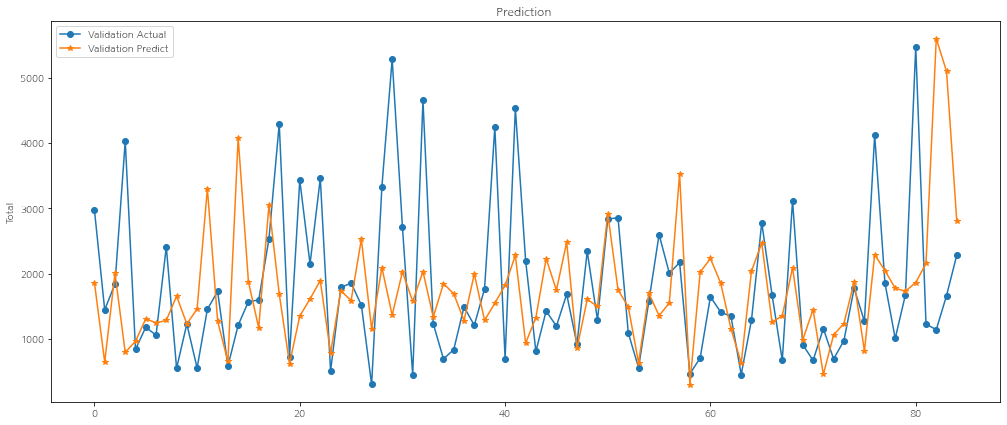

In [37]:
# XGB 도로명 - 변수 50개 모델 (최종모델)
import xgboost as xgb

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  3, 
                       min_child_weight = 1, 
                        n_estimators =500, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

print('train R2 score : {}'.format(xgb_model.score(X_train, y_train)))
print('test R2 score : {}'.format(xgb_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 mean_squared_error(y_true, y_pred)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('rmse:',rmse)
print('std:',std) 
print('mean',mean)


# 예측값과 실제값 그래프 출력 
pred_train = xgb_model.predict(X_train)
pred_val = xgb_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Total')
plt.legend()

## 동명씨 Data 포함

In [38]:
df_feature = pd.read_csv('/content/drive/My Drive/Project/Seoul/가공데이터/total_합치기.csv').drop(['Unnamed: 0','시군구명','행정동명','5~9세', '10~14세','5~14세'], axis=1)
df_feature

,행정동코드,공동주택_개수,공동주택_건축면적(㎡),공동주택_건폐율(%),공동주택_연면적(㎡),공동주택_용적률(%),공동주택_세대수,공동주택_가구수,단독주택_개수,단독주택_건축면적(㎡),단독주택_건폐율(%),단독주택_가구수,공장_개수,공장_건축면적(㎡),동별총학원,동별입시학원수,버스정류장,도서관,박물관/미술관,공원,지하철역,병원수,유통개수,아동 비율
0,1111051500,379,125.269681,52.555743,191.928277,964.553177,7.379947,0.005277,1559.0,23.462012,13.678553,1.304041,1.0,0.00,58.380856,5.365593,25.0,3.0,1.0,0.0,0.0,6,0,0.101799
1,1111053000,98,348.211020,44.991429,153.290797,3228.286531,17.010204,0.071429,946.0,12.173044,8.226060,1.180761,4.0,0.00,44.447564,4.085030,24.0,0.0,5.0,2.0,2.0,37,1,0.099424
2,1111054000,14,203.559286,34.089286,113.165714,746.249643,4.357143,0.000000,729.0,18.521756,11.591167,1.226337,2.0,0.00,13.501850,1.240911,23.0,1.0,7.0,1.0,0.0,86,0,0.059029
3,1111055000,246,124.504472,24.580998,61.007185,902.087581,6.914634,0.069106,1109.0,33.162876,11.441231,1.220018,1.0,0.00,47.326869,4.349657,60.0,0.0,5.0,0.0,0.0,12,0,0.030142
4,1111056000,454,389.523883,20.485875,59.479189,1422.534819,8.856828,0.002203,1625.0,67.452961,15.599884,1.156923,2.0,0.00,84.907700,7.803588,34.0,1.0,6.0,0.0,0.0,65,5,0.029561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1174065000,1247,193.674798,46.141739,178.642433,1268.791290,13.827586,0.003208,1944.0,84.791241,40.042056,3.489198,0.0,0.00,118.099591,22.728190,25.0,0.0,0.0,0.0,1.0,12,0,0.070858
421,1174066000,1247,193.674798,46.141739,178.642433,1268.791290,13.827586,0.003208,1944.0,84.791241,40.042056,3.489198,0.0,0.00,112.113670,21.576204,25.0,1.0,0.0,0.0,1.0,15,0,0.063964
422,1174068500,683,232.939603,41.283617,176.225471,1810.938666,20.751098,0.055637,805.0,95.671335,39.313429,4.043478,0.0,0.00,220.942613,42.520263,16.0,0.0,0.0,1.0,1.0,28,0,0.043771
423,1174069000,359,231.635373,36.682957,139.272450,2113.655245,20.142061,0.000000,594.0,77.712534,34.458581,2.462963,1.0,1109.58,1.289420,0.248148,46.0,0.0,0.0,0.0,0.0,8,0,0.068439


In [39]:
df_1 = target_pop.merge(df_feature, on='행정동코드')
df = df_1.merge(move.drop(['자치구','행정동'], axis=1), on='행정동코드')
df

,행정동코드,자치구,행정동,05-09세,10-14세,05-14세,공동주택_개수,공동주택_건축면적(㎡),공동주택_건폐율(%),공동주택_연면적(㎡),공동주택_용적률(%),공동주택_세대수,공동주택_가구수,단독주택_개수,단독주택_건축면적(㎡),단독주택_건폐율(%),단독주택_가구수,공장_개수,공장_건축면적(㎡),동별총학원,동별입시학원수,버스정류장,도서관,박물관/미술관,공원,지하철역,병원수,유통개수,아동 비율,총전입_00 - 04세,총전입_05 - 09세,총전입_10 - 14세,총전입_15 - 19세,총전입_20 - 24세,총전입_25 - 29세,총전입_30 - 34세,총전입_35 - 39세,총전입_40 - 44세,총전입_45 - 49세,총전입_50 - 54세,총전입_55 - 59세,총전입_60 - 64세,총전입_65 - 69세,총전입_70 - 74세,총전입_75 - 79세,총전입_80세이상,총전출_00 - 04세,총전출_05 - 09세,총전출_10 - 14세,총전출_15 - 19세,총전출_20 - 24세,총전출_25 - 29세,총전출_30 - 34세,총전출_35 - 39세,총전출_40 - 44세,총전출_45 - 49세,총전출_50 - 54세,총전출_55 - 59세,총전출_60 - 64세,총전출_65 - 69세,총전출_70 - 74세,총전출_75 - 79세,총전출_80세이상
0,1168066000,강남구,개포1동,270,288,558,629,269.017886,36.968351,133.345931,2976.035567,28.483307,0.000000,358.0,92.183317,32.172585,4.069832,0.0,0.00,88.875012,15.395968,18.0,0.0,0.0,0.0,0.0,1,0,0.063987,4.951676,7.482255,8.902299,12.273633,20.145777,18.225438,15.850075,13.518597,13.246507,6.388350,8.409857,6.512616,5.161403,3.443861,2.374439,1.605749,1.975774,14.465583,12.801792,25.096178,33.279222,47.965662,51.125620,43.395616,30.940400,34.888648,12.014634,28.886994,22.559151,16.808935,11.011149,7.438925,4.923418,5.727564
1,1168067000,강남구,개포2동,944,1136,2080,979,799.580737,32.101393,121.000889,2940.591695,29.281920,0.000000,967.0,97.405425,26.323076,2.538780,0.0,0.00,292.316180,50.638423,35.0,0.0,1.0,0.0,0.0,28,0,0.078849,84.162464,127.174123,151.310276,208.612045,342.413010,309.773458,269.399972,229.772399,225.147743,108.581278,142.940354,110.693387,87.727140,58.534487,40.357782,27.292539,33.581757,23.509006,20.805065,40.785512,54.084335,77.952271,83.087733,70.525177,50.283356,56.699923,19.525801,46.946226,36.662416,27.317347,17.894970,12.089504,8.001382,9.308256
2,1168069000,강남구,개포4동,629,739,1368,629,269.017886,36.968351,133.345931,2976.035567,28.483307,0.000000,358.0,92.183317,32.172585,4.069832,0.0,0.00,236.239198,40.924114,18.0,1.0,0.0,0.0,0.0,16,0,0.068792,17.643350,26.660074,31.719843,43.732266,71.781554,64.939181,56.475508,48.168205,47.198718,22.762374,29.965219,23.205145,18.390628,12.270844,8.460380,5.721456,7.039892,27.023189,23.915056,46.882228,62.168991,89.604763,95.507887,81.067450,57.799833,65.175564,22.444565,53.963860,42.142802,31.400810,20.569953,13.896673,9.197448,10.699676
3,1168052100,강남구,논현1동,364,386,750,961,261.955671,45.161495,163.530525,1419.158716,13.428720,0.056191,1410.0,132.040855,47.608796,6.975177,0.0,0.00,310.161213,53.729749,15.0,1.0,0.0,0.0,2.0,29,1,0.131267,41.584462,62.836415,74.762027,103.074687,169.185408,153.058287,133.109849,113.529965,111.244934,53.649736,70.626470,54.693324,43.345759,28.921743,19.940679,13.485175,16.592662,53.608321,47.442441,93.004477,123.330199,177.757000,189.467555,160.820766,114.662709,129.294607,44.525295,107.052946,83.602454,62.292601,40.806459,27.568075,18.245801,21.225907
4,1168053100,강남구,논현2동,616,565,1181,961,261.955671,45.161495,163.530525,1419.158716,13.428720,0.056191,1410.0,132.040855,47.608796,6.975177,0.0,0.00,283.380694,49.090514,15.0,1.0,0.0,0.0,1.0,32,0,0.043701,34.557569,52.218392,62.128829,85.657249,140.596660,127.194680,110.617106,94.345807,92.446898,44.584068,58.692093,45.451312,36.021245,24.034581,16.571127,11.206466,13.788854,46.219776,40.903706,80.186173,106.332265,153.257715,163.354268,138.655711,98.859368,111.474632,38.388615,92.298418,72.079980,53.707149,35.182326,23.768516,15.731081,18.300455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1126059000,중랑구,상봉제2동,351,341,692,562,203.985837,42.190352,183.659167,1994.888895,20.887900,0.000000,1484.0,68.910519,39.724194,2.731806,5.0,549.34,39.428404,8.126465,28.0,1.0,0.0,0.0,1.0,19,0,0.076154,40.320349,28.471514,45.129687,97.955497,151.118493,135.406807,109.609119,75.955588,84.473972,30.293502,81.628595,77.955042,59.185020,34.511285,24.064434,18

In [40]:
y = df[['05-14세']]
X = df.drop(['행정동코드', '자치구', '행정동', '05-09세', '10-14세', '05-14세'], axis=1)

X.shape, y.shape

((425, 57), (425, 1))

In [41]:
X.columns

Index(['공동주택_개수', '공동주택_건축면적(㎡)', '공동주택_건폐율(%)', '공동주택_연면적(㎡)', '공동주택_용적률(%)',
       '공동주택_세대수', '공동주택_가구수', '단독주택_개수', '단독주택_건축면적(㎡)', '단독주택_건폐율(%)',
       '단독주택_가구수', '공장_개수', '공장_건축면적(㎡)', '동별총학원', '동별입시학원수', '버스정류장', '도서관',
       '박물관/미술관', '공원', '지하철역', '병원수', '유통개수', '아동 비율', '총전입_00 - 04세',
       '총전입_05 - 09세', '총전입_10 - 14세', '총전입_15 - 19세', '총전입_20 - 24세',
       '총전입_25 - 29세', '총전입_30 - 34세', '총전입_35 - 39세', '총전입_40 - 44세',
       '총전입_45 - 49세', '총전입_50 - 54세', '총전입_55 - 59세', '총전입_60 - 64세',
       '총전입_65 - 69세', '총전입_70 - 74세', '총전입_75 - 79세', '총전입_80세이상',
       '총전출_00 - 04세', '총전출_05 - 09세', '총전출_10 - 14세', '총전출_15 - 19세',
       '총전출_20 - 24세', '총전출_25 - 29세', '총전출_30 - 34세', '총전출_35 - 39세',
       '총전출_40 - 44세', '총전출_45 - 49세', '총전출_50 - 54세', '총전출_55 - 59세',
       '총전출_60 - 64세', '총전출_65 - 69세', '총전출_70 - 74세', '총전출_75 - 79세',
       '총전출_80세이상'],
      dtype='object')

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape

((340, 57), (85, 57), (340, 1))

train R2 score : 0.9999985554723071
test R2 score : 0.4447812805132807
rmse: 875.5960163425002
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64


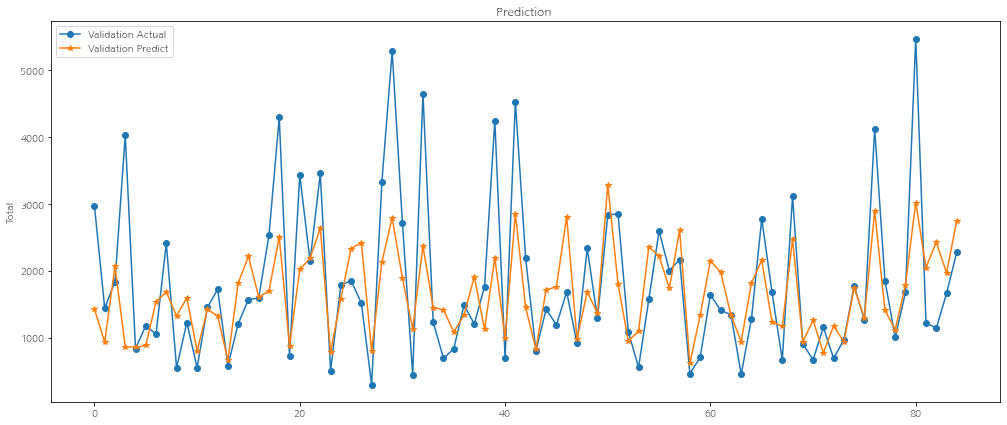

In [43]:
# XGB 도로명 - 변수 50개 모델 (최종모델)
import xgboost as xgb

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  6, 
                       min_child_weight = 1, 
                        n_estimators =500, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

print('train R2 score : {}'.format(xgb_model.score(X_train, y_train)))
print('test R2 score : {}'.format(xgb_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 mean_squared_error(y_true, y_pred)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('rmse:',rmse)
print('std:',std) 
print('mean',mean)


# 예측값과 실제값 그래프 출력 
pred_train = xgb_model.predict(X_train)
pred_val = xgb_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Total')
plt.legend()

## ExtraTreesRegressor

전체 트리 모델에서 각 변수의 중요도 추출

In [44]:
from sklearn.ensemble import ExtraTreesRegressor

etc_model = ExtraTreesRegressor()
etc_model.fit(X_train, y_train)

# print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)

# 중요도 순으로 특성 출력 
feature_list = feature_list.sort_values("importance", ascending =False).reset_index()
feature_list[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,index,features_name,importance
0,14,동별입시학원수,0.187069
1,13,동별총학원,0.123100
2,16,도서관,0.032077
3,2,공동주택_건폐율(%),0.031312
4,3,공동주택_연면적(㎡),0.030261
5,51,총전출_55 - 59세,0.026502
6,48,총전출_40 - 44세,0.026108
7,42,총전출_10 - 14세,0.025626
8,15,버스정류장,0.024464
9,32,총전입_45 - 49세,0.021852


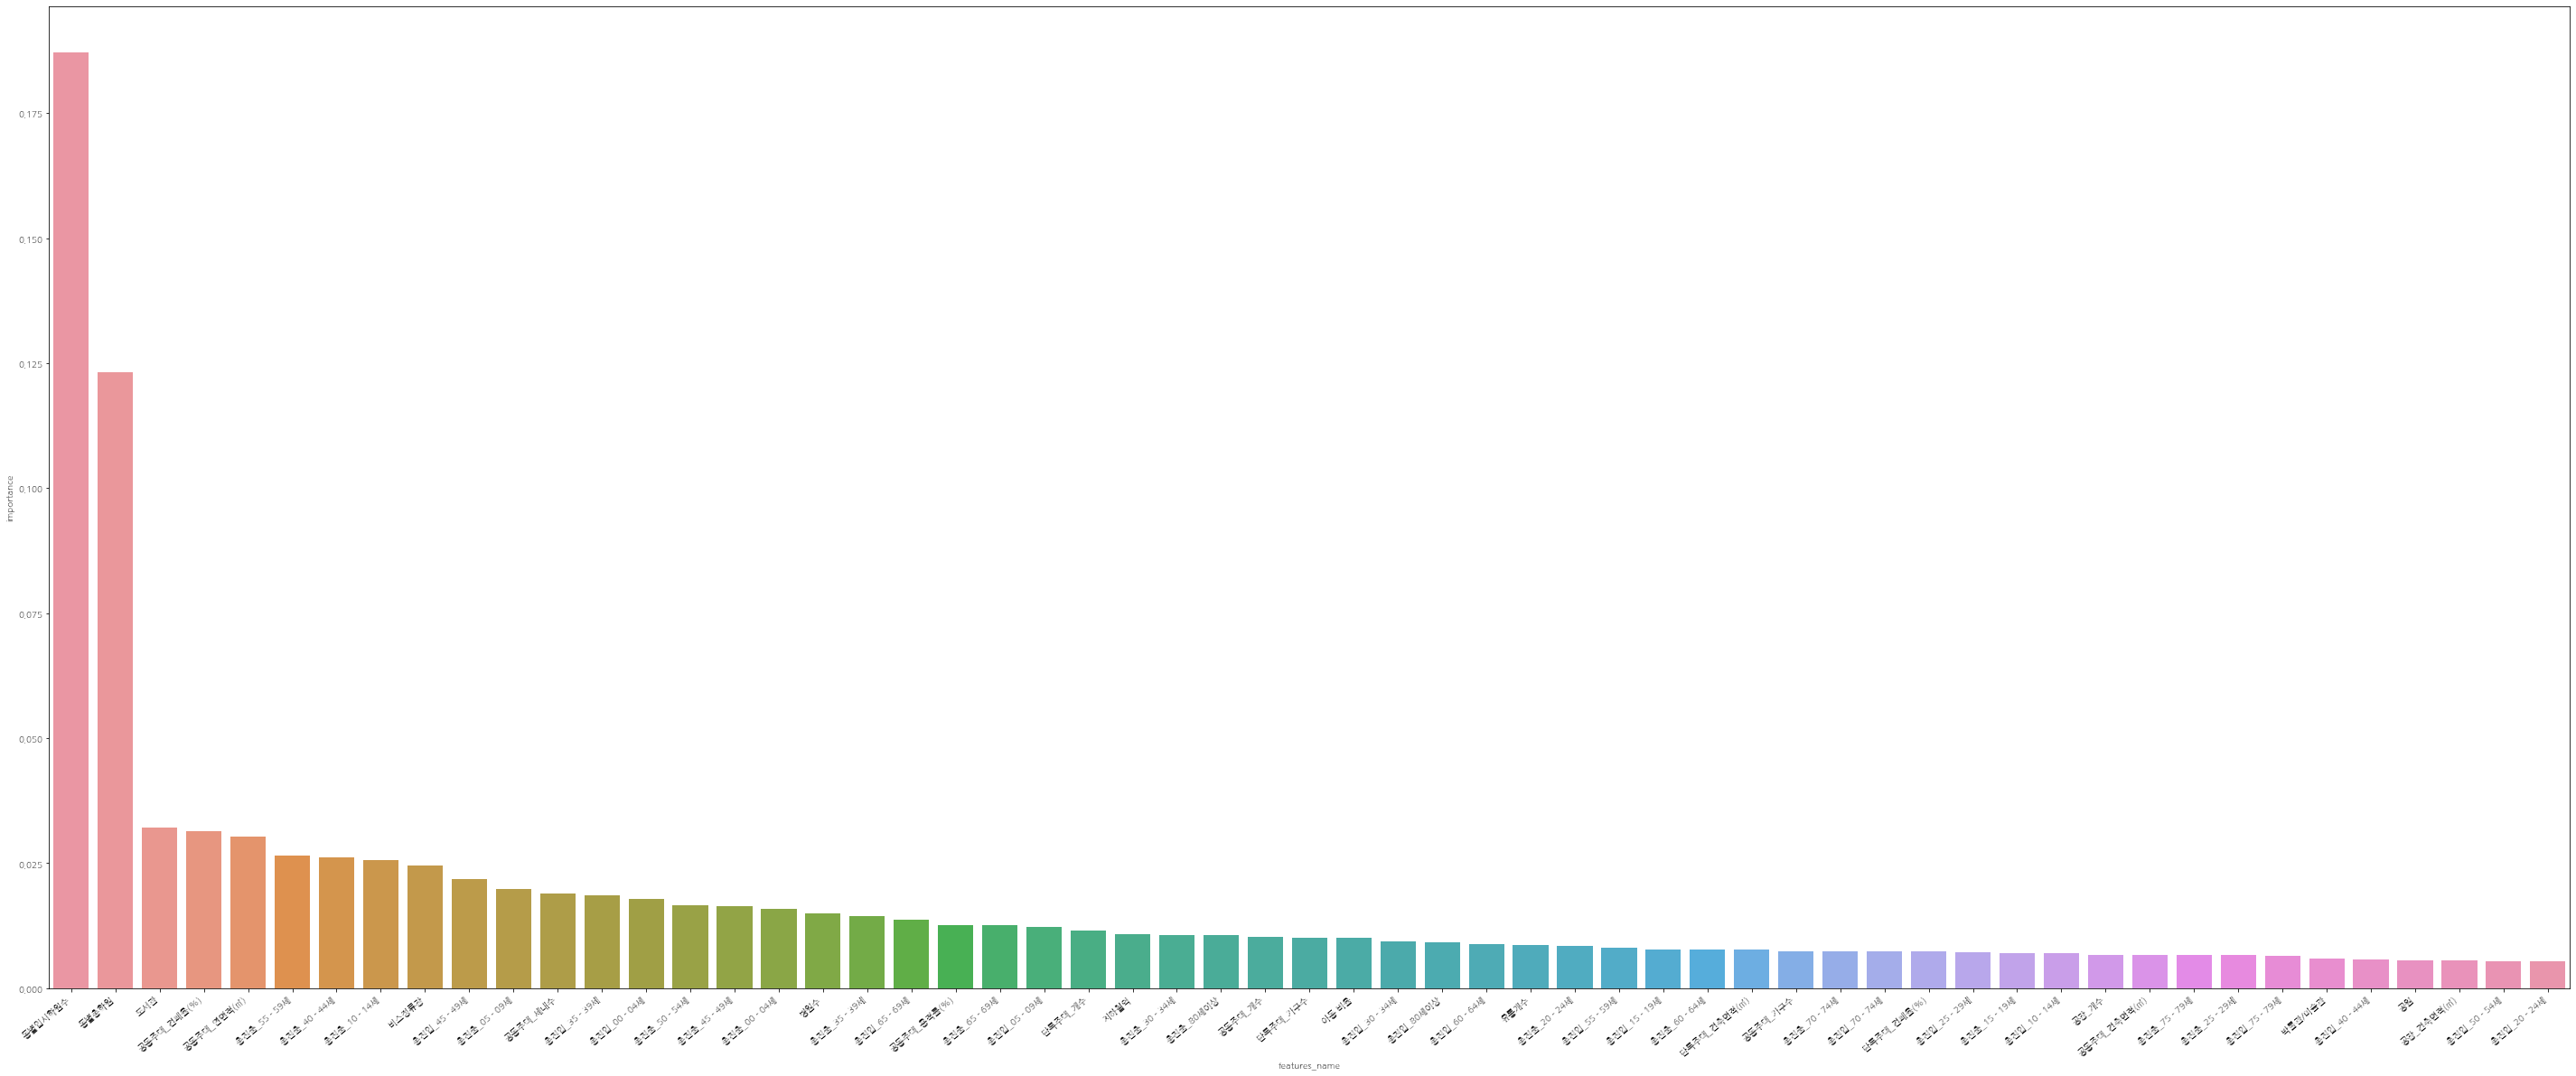

In [45]:
# 특성 중요도 그래프 그리기
plt.figure(figsize = (50,20))
ax = sns.barplot(x = feature_list['features_name'], y = feature_list['importance'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

fig = plt.gcf()
fig.savefig('graph.png', dpi=300, format='png', bbox_inches="tight", facecolor="white")


## RFE

In [46]:
# XGBoost model with RFE and 20 features
import xgboost as xgb
from sklearn.feature_selection import RFE

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  7, 
                       min_child_weight = 1, 
                        n_estimators =1000, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror').fit(X_train, y_train)

selector = RFE(xgb_model, 20, step=1)
selector.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=0.5, gamma=0.0,
                           importance_type='gain', learning_rate=0.05,
                           max_delta_step=0, max_depth=7, min_child_weight=1,
                           missing=None, n_estimators=1000, n_jobs=1,
                           nthread=None, objective='reg:squarederror',
                           random_state=545, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=None, silent=None,
                           subsample=1.0, verbosity=1),
    n_features_to_select=20, step=1, verbose=0)

train R2 score : 0.9999999999677041
test R2 score : 0.3994262261175533


-----------
rmse: 910.6571642536654
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




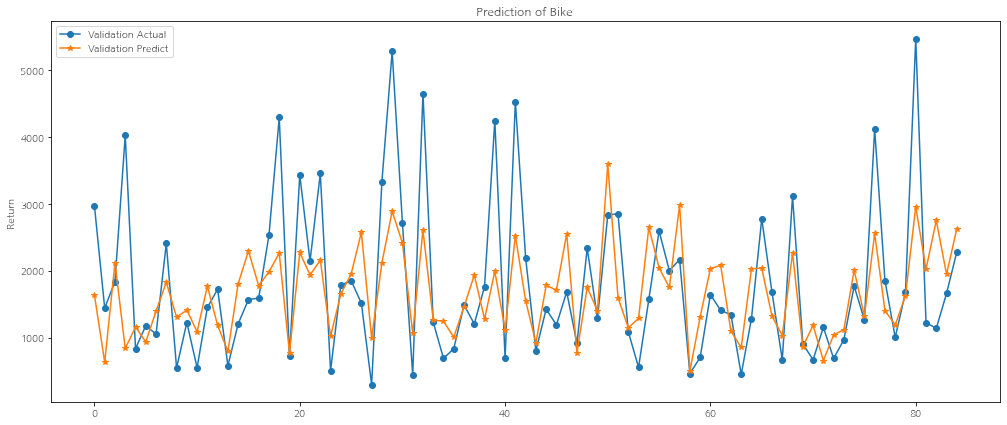

In [47]:
print('train R2 score : {}'.format(selector.score(X_train, y_train)))
print('test R2 score : {}'.format(selector.score(X_test, y_test)))


# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, selector.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')

pred_train = selector.predict(X_train)
pred_val = selector.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction of Bike ')
plt.ylabel('Return')
plt.legend()

In [48]:
feature_rank = pd.DataFrame([X_train.columns, selector.ranking_]).T
feature_rank = feature_rank.sort_values(1, ascending = True).reset_index()

print(feature_rank[:50])
print(feature_rank[50:100])
print(feature_rank[100:150])
print(feature_rank[150:200])

    index             0   1
0      20           병원수   1
1      37  총전입_70 - 74세   1
2      36  총전입_65 - 69세   1
3      35  총전입_60 - 64세   1
4      34  총전입_55 - 59세   1
5      32  총전입_45 - 49세   1
6      43  총전출_15 - 19세   1
7      44  총전출_20 - 24세   1
8      27  총전입_20 - 24세   1
9      23  총전입_00 - 04세   1
10     40  총전출_00 - 04세   1
11     47  총전출_35 - 39세   1
12     48  총전출_40 - 44세   1
13     14       동별입시학원수   1
14     41  총전출_05 - 09세   1
15     50  총전출_50 - 54세   1
16     51  총전출_55 - 59세   1
17      2   공동주택_건폐율(%)   1
18      5      공동주택_세대수   1
19     13         동별총학원   1
20      4   공동주택_용적률(%)   2
21     39     총전입_80세이상   3
22     29  총전입_30 - 34세   4
23      8  단독주택_건축면적(㎡)   5
24     10      단독주택_가구수   6
25     52  총전출_60 - 64세   7
26     53  총전출_65 - 69세   8
27      3   공동주택_연면적(㎡)   9
28     26  총전입_15 - 19세  10
29      9   단독주택_건폐율(%)  11
30     49  총전출_45 - 49세  12
31     28  총전입_25 - 29세  13
32     45  총전출_25 - 29세  14
33      1  공동주택_건축면적(㎡)  15
34     30  총전입_35 - 

## Model Grid Search

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 
from sklearn import linear_model as lm 
import xgboost as xgb 
from scipy.stats import uniform, randint 

models = [ 
          ('lr', lm.LinearRegression(n_jobs=-1)),
          ('ridge', lm.Ridge()), ('lasso', lm.Lasso()), 
          ('elastic', lm.ElasticNet()), 
          ('LassoLars', lm.LassoLars()), 
          # ('LogisticRegression', lm.LogisticRegression()), 
          ('SGDRegressor', lm.SGDRegressor()), 
          ('Perceptron', lm.Perceptron(n_jobs=-1)), 
          ('xgboost', xgb.XGBRegressor())
          ] 
 
n = 3 
params = { 'lr' : { 'fit_intercept': [True, False], 'normalize': [True, False], }, 
          'ridge': { 'alpha': [0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], 
                    'normalize': [True, False], }, 
          'lasso': { 'alpha': [0.1, 1.0, 10], 'fit_intercept': [True, False], 'normalize': [True, False], }, 
          'elastic': { 'alpha': [0.1, 1.0, 10], 'normalize': [True, False], 'fit_intercept': [True, False], }, 
          'LassoLars': { 'alpha': [0.1, 1.0, 10], 'normalize': [True, False], 'fit_intercept': [True, False], },  
          # 'LogisticRegression': { 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], },
          'SGDRegressor': { 'penalty': ['l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], },
          'Perceptron' :{ 'penalty': ['None', 'l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False] },
          'xgboost': { "gamma": uniform(0, 0.5).rvs(n), 
                      "max_depth": range(2, 7), # default 3 
                      "n_estimators": randint(100, 150).rvs(n), # default 100 
                      }

}

best_model, best_rmse = None, float('inf') 

for model_name, model in models: 
  param_grid = params[model_name] 
  grid = GridSearchCV(model, cv=3, n_jobs=-1, param_grid=param_grid) 
  grid = grid.fit(X_train, y_train) 

  model = grid.best_estimator_ 
  predictions = model.predict(X_test) 
  rmse = np.sqrt(mean_squared_error(y_train,model.predict(X_train)))
  print(model_name, rmse) 
  
  if rmse < best_rmse: 
    best_model = model


lr 564.1514500027375
ridge 676.7278977381362
lasso 817.9475792208564
elastic 934.4980858624922
LassoLars 817.9482023090821


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


SGDRegressor 2.0569829728285044e+16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Perceptron 1234.31193621481
[10:10:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost 203.35777238433695


In [50]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.11433500497307669,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=122,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

train R2 score : 0.9680460722008515
test R2 score : 0.4855137302360574


-----------
rmse: 842.8661671297535
std: 05-14세    1182.065513
dtype: float64
mean 05-14세    1799.2
dtype: float64
-----------




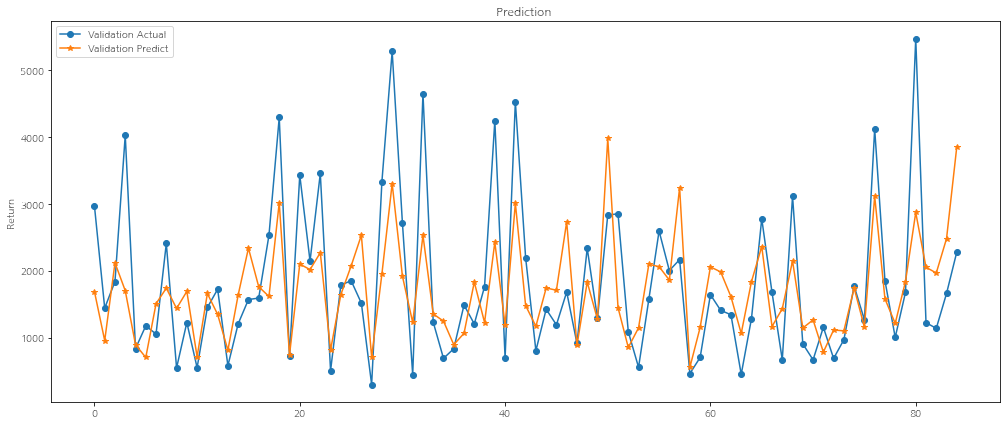

In [51]:
print('train R2 score : {}'.format(best_model.score(X_train, y_train)))
print('test R2 score : {}'.format(best_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
std = y_test.std()
mean = y_test.mean()

print('\n')
print('-----------')
print('rmse:',rmse)
print('std:',std) 
print('mean',mean)
print('-----------')
print('\n')

pred_train = best_model.predict(X_train)
pred_val = best_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction ')
plt.ylabel('Return')
plt.legend()

[Text(0, 0, '공동주택_개수'),
 Text(0, 0, '공동주택_건축면적(㎡)'),
 Text(0, 0, '공동주택_건폐율(%)'),
 Text(0, 0, '공동주택_연면적(㎡)'),
 Text(0, 0, '공동주택_용적률(%)'),
 Text(0, 0, '공동주택_세대수'),
 Text(0, 0, '공동주택_가구수'),
 Text(0, 0, '단독주택_개수'),
 Text(0, 0, '단독주택_건축면적(㎡)'),
 Text(0, 0, '단독주택_건폐율(%)'),
 Text(0, 0, '단독주택_가구수'),
 Text(0, 0, '공장_개수'),
 Text(0, 0, '공장_건축면적(㎡)'),
 Text(0, 0, '동별총학원'),
 Text(0, 0, '동별입시학원수'),
 Text(0, 0, '버스정류장'),
 Text(0, 0, '도서관'),
 Text(0, 0, '박물관/미술관'),
 Text(0, 0, '공원'),
 Text(0, 0, '지하철역'),
 Text(0, 0, '병원수'),
 Text(0, 0, '유통개수'),
 Text(0, 0, '아동 비율'),
 Text(0, 0, '총전입_00 - 04세'),
 Text(0, 0, '총전입_05 - 09세'),
 Text(0, 0, '총전입_10 - 14세'),
 Text(0, 0, '총전입_15 - 19세'),
 Text(0, 0, '총전입_20 - 24세'),
 Text(0, 0, '총전입_25 - 29세'),
 Text(0, 0, '총전입_30 - 34세'),
 Text(0, 0, '총전입_35 - 39세'),
 Text(0, 0, '총전입_40 - 44세'),
 Text(0, 0, '총전입_45 - 49세'),
 Text(0, 0, '총전입_50 - 54세'),
 Text(0, 0, '총전입_55 - 59세'),
 Text(0, 0, '총전입_60 - 64세'),
 Text(0, 0, '총전입_65 - 69세'),
 Text(0, 0, '총전입_70 - 74세'),
 Text(0,

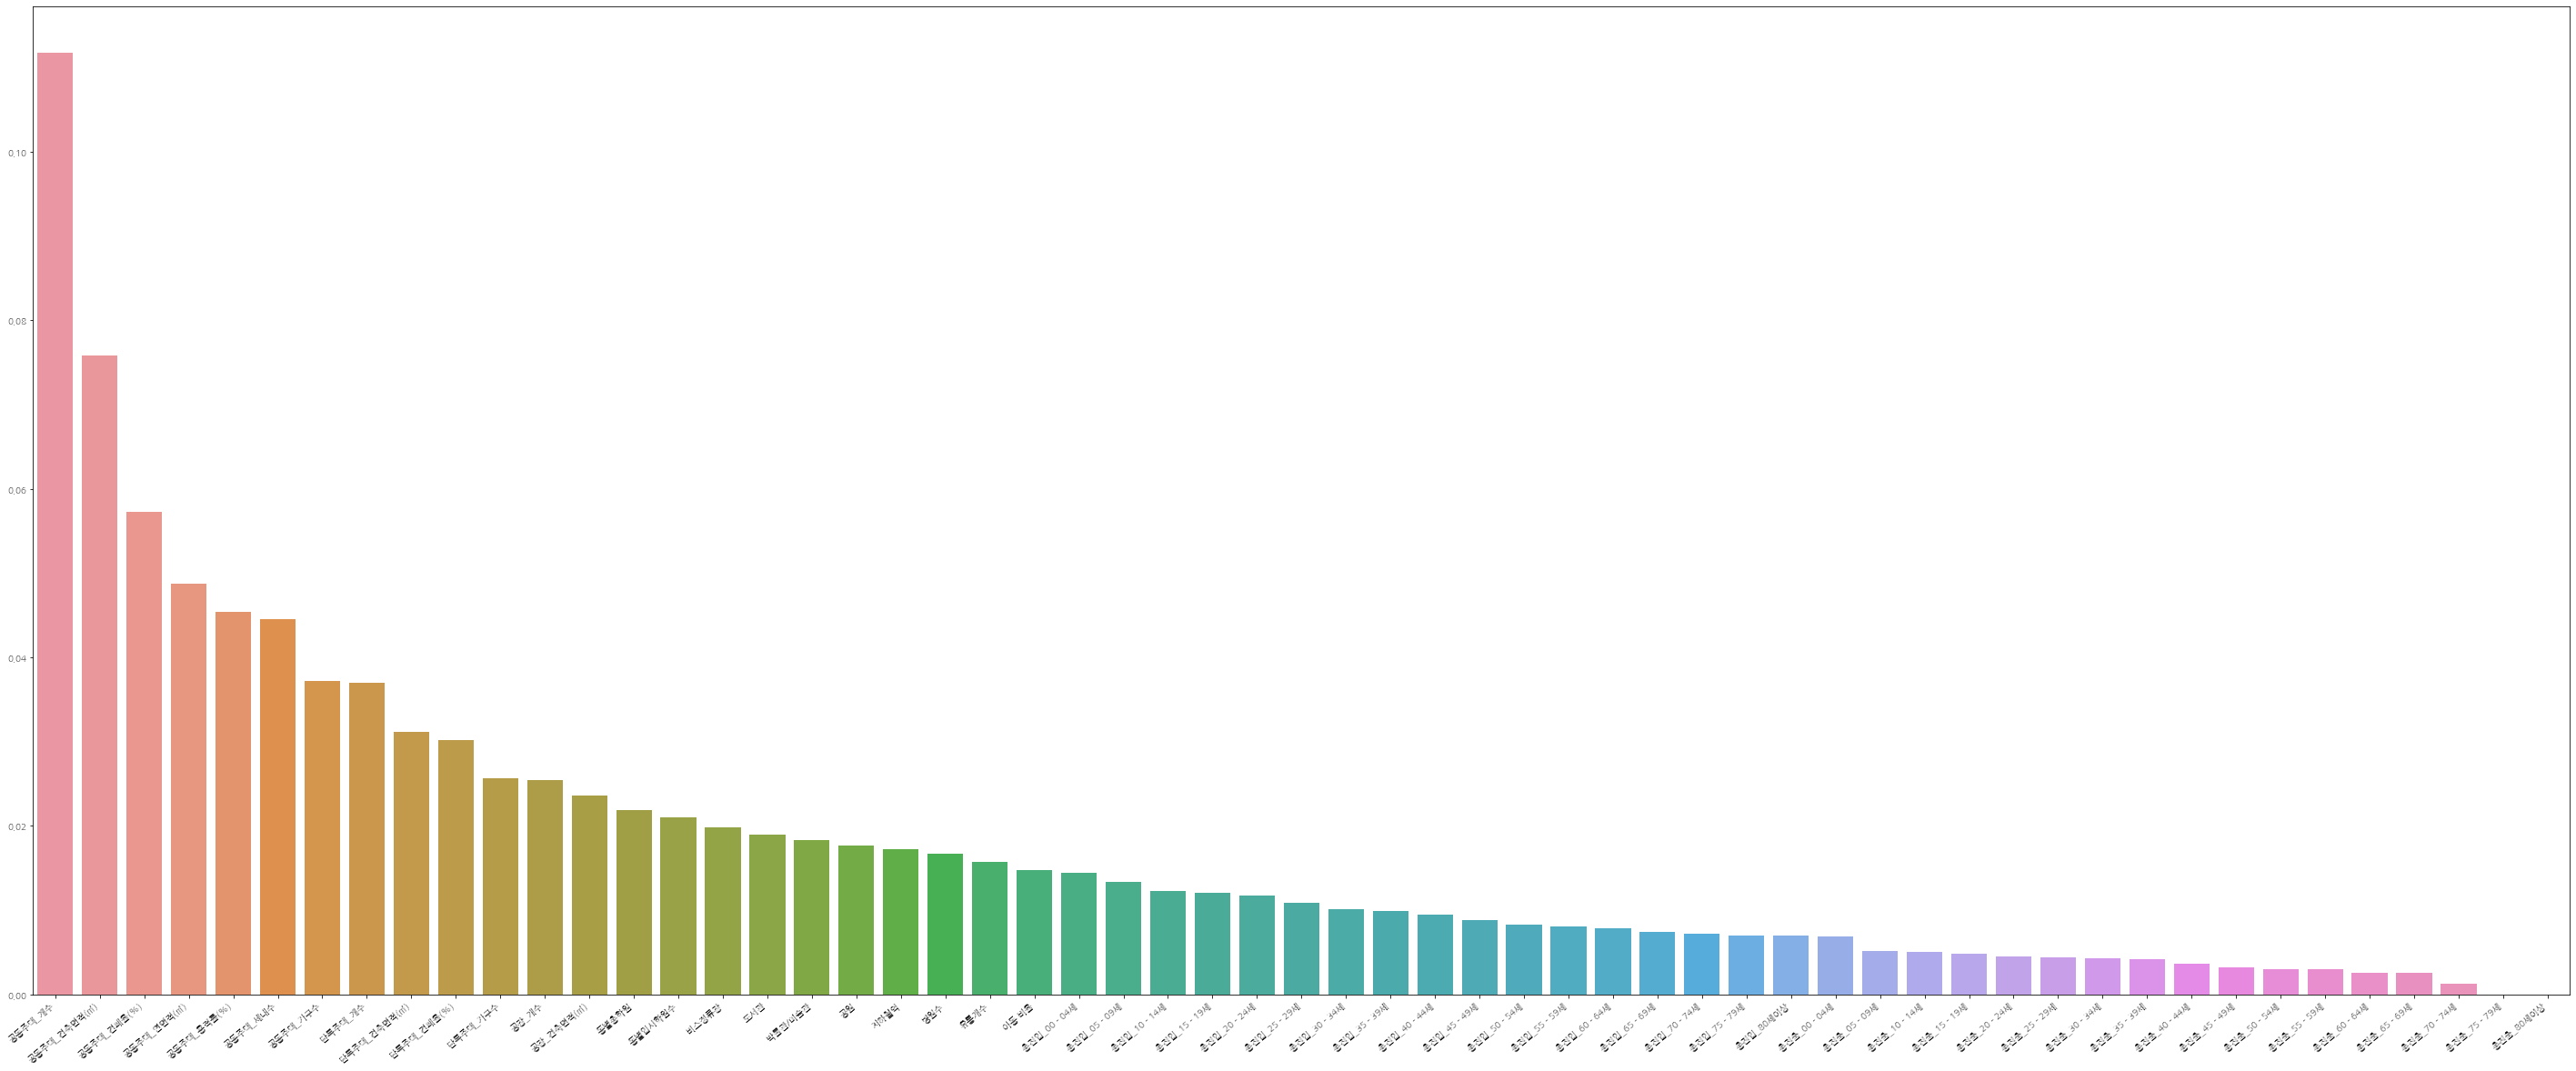

In [52]:
# 특성 중요도 그래프 그리기
features = X.columns
feature_importance = pd.Series(index=features, data=best_model.feature_importances_).sort_values(ascending=False) 

plt.figure(figsize = (50,20))
ax = sns.barplot(x = features, y = feature_importance)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# fig = plt.gcf()
# fig.savefig('graph.png', dpi=300, format='png', bbox_inches="tight", facecolor="white")
